In [1]:
import os
import time
import pickle
from collections import namedtuple

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms
import torch.utils.checkpoint as checkpoint

from transformers.modeling_gpt2 import *
from transformers import GPT2Tokenizer

from efficientnet_pytorch import *

import matplotlib.pyplot as plt
import pickle

#from apex import amp

#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Define and Load our Model

In [2]:
#efficientnet-b0-224
#efficientnet-b1-240
#efficientnet-b2-260
#efficientnet-b3-300
#efficientnet-b4-380
#efficientnet-b5-456
#efficientnet-b6-528
#efficientnet-b7-600

In [3]:
EFFNET = EFFNET = "efficientnet-b4"  #"efficientnet-b2" #EFFNET = "efficientnet-b0"
IMG_SIZE = 380  #260 #IMG_SIZE = 224

GPT = "gpt2"

MAX_LENGTH = 36
EFFNET_OUT = 1000

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained(GPT)

In [5]:
class EfficientNetCheck(EfficientNet):

    def run_block(self, block, drop_connect_rate):
        def custom_forward(*inputs):
            x = block(inputs[0], drop_connect_rate=drop_connect_rate)
            return x
        return custom_forward
    
    def extract_features(self, inputs):

        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks) # scale drop connect_rate
            x = checkpoint.checkpoint(self.run_block(block, drop_connect_rate), x)
            #x = block(x, drop_connect_rate=drop_connect_rate)
        
        # Head
        x = self._swish(self._bn1(self._conv_head(x)))

        return x

In [6]:
class Block(nn.Module):
    
    def __init__(self, n_ctx, config, scale=False):
        super().__init__()
        nx = config.n_embd
        self.ln_1 = nn.LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.attn = Attention(nx, n_ctx, config, scale)
        self.ln_2 = nn.LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.mlp = MLP(4 * nx, config)
        
    def forward(self, x, layer_past=None, attention_mask=None, head_mask=None, use_cache=False):
        output_attn = self.attn(
            self.ln_1(x),
            layer_past=layer_past,
            attention_mask=attention_mask,
            head_mask=head_mask,
            use_cache=use_cache,
        )
        a = output_attn[0]  # output_attn: a, present, (attentions)

        x = x + a
        m = self.mlp(self.ln_2(x))
        x = x + m

        outputs = [x] + output_attn[1:]
        return outputs[0], outputs[1]

class GPT2Model(GPT2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.output_hidden_states = config.output_hidden_states
        self.output_attentions = config.output_attentions

        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.wpe = nn.Embedding(config.n_positions, config.n_embd)
        self.drop = nn.Dropout(config.embd_pdrop)
        self.h = nn.ModuleList([Block(config.n_ctx, config, scale=True) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)

        self.init_weights()

    def get_input_embeddings(self):
        return self.wte


    def set_input_embeddings(self, new_embeddings):
        self.wte = new_embeddings


    def _prune_heads(self, heads_to_prune):
        for layer, heads in heads_to_prune.items():
            self.h[layer].attn.prune_heads(heads)
    
    def run_block(self, block, layer_past, attention_mask, head_mask, use_cache):
        def custom_forward(*inputs):
            x, present = block(
                inputs[0],
                layer_past=layer_past,
                attention_mask=attention_mask,
                head_mask=head_mask,
                use_cache=use_cache,
            )
            return x, present
        return custom_forward

    def forward(
        self,
        input_ids=None,
        past=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        use_cache=True,
    ):

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
            batch_size = input_ids.shape[0]
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
            batch_size = inputs_embeds.shape[0]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        if token_type_ids is not None:
            token_type_ids = token_type_ids.view(-1, input_shape[-1])
        if position_ids is not None:
            position_ids = position_ids.view(-1, input_shape[-1])

        if past is None:
            past_length = 0
            past = [None] * len(self.h)
        else:
            past_length = past[0][0].size(-2)
        if position_ids is None:
            device = input_ids.device if input_ids is not None else inputs_embeds.device
            position_ids = torch.arange(past_length, input_shape[-1] + past_length, dtype=torch.long, device=device)
            position_ids = position_ids.unsqueeze(0).view(-1, input_shape[-1])

        # Attention mask.
        if attention_mask is not None:
            assert batch_size > 0, "batch_size has to be defined and > 0"
            attention_mask = attention_mask.view(batch_size, -1)
            attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

            attention_mask = attention_mask.to(dtype=next(self.parameters()).dtype)  # fp16 compatibility
            attention_mask = (1.0 - attention_mask) * -10000.0

        head_mask = self.get_head_mask(head_mask, self.config.n_layer)

        if inputs_embeds is None:
            inputs_embeds = self.wte(input_ids)
        position_embeds = self.wpe(position_ids)
        if token_type_ids is not None:
            token_type_embeds = self.wte(token_type_ids)
        else:
            token_type_embeds = 0
        hidden_states = inputs_embeds + position_embeds + token_type_embeds
        hidden_states = self.drop(hidden_states)

        output_shape = input_shape + (hidden_states.size(-1),)

        presents = ()
        all_attentions = []
        all_hidden_states = ()
        for i, (block, layer_past) in enumerate(zip(self.h, past)):
            if self.output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states.view(*output_shape),)
            
            hidden_states, present = checkpoint.checkpoint(
                self.run_block(block, layer_past, attention_mask, head_mask[i], use_cache),
                hidden_states
            )
            
            
            '''
            outputs = block(
                hidden_states,
                layer_past=layer_past,
                attention_mask=attention_mask,
                head_mask=head_mask[i],
                use_cache=use_cache,
            )
            hidden_states, present = outputs[:2]
            '''
            
            if use_cache is True:
                presents = presents + (present,)

            if self.output_attentions:
                all_attentions.append(outputs[2])

        hidden_states = self.ln_f(hidden_states)

        hidden_states = hidden_states.view(*output_shape)
        # Add last hidden state
        if self.output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        outputs = (hidden_states,)
        if use_cache is True:
            outputs = outputs + (presents,)
        if self.output_hidden_states:
            outputs = outputs + (all_hidden_states,)
        if self.output_attentions:
            # let the number of heads free (-1) so we can extract attention even after head pruning
            attention_output_shape = input_shape[:-1] + (-1,) + all_attentions[0].shape[-2:]
            all_attentions = tuple(t.view(*attention_output_shape) for t in all_attentions)
            outputs = outputs + (all_attentions,)
        return outputs  # last hidden state, (presents), (all hidden_states), (attentions)


In [ ]:
 @torch.no_grad()
    def generate(self, input_ids=None, max_length=None, min_length=None, do_sample=None, early_stopping=None, num_beams=None,
                 temperature=None, top_k=None, top_p=None, repetition_penalty=None, bad_words_ids=None, bos_token_id=None,
                 pad_token_id=None, eos_token_id=None, length_penalty=None, no_repeat_ngram_size=None, attention_mask=None,
                 num_return_sequences=None, decoder_start_token_id=None, use_cache=None, **model_specific_kwargs
    ):

        # We cannot generate if the model does not have a LM head
        if self.get_output_embeddings() is None:
            raise AttributeError(
                "You tried to generate sequences with a model that does not have a LM Head."
                "Please use another model class (e.g. `OpenAIGPTLMHeadModel`, `XLNetLMHeadModel`, `GPT2LMHeadModel`, `CTRLLMHeadModel`, `T5WithLMHeadModel`, `TransfoXLLMHeadModel`, `XLMWithLMHeadModel`, `BartForConditionalGeneration` )"
            )

        max_length = max_length if max_length is not None else self.config.max_length
        min_length = min_length if min_length is not None else self.config.min_length
        do_sample = do_sample if do_sample is not None else self.config.do_sample
        early_stopping = early_stopping if early_stopping is not None else self.config.early_stopping
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        num_beams = num_beams if num_beams is not None else self.config.num_beams
        temperature = temperature if temperature is not None else self.config.temperature
        top_k = top_k if top_k is not None else self.config.top_k
        top_p = top_p if top_p is not None else self.config.top_p
        repetition_penalty = repetition_penalty if repetition_penalty is not None else self.config.repetition_penalty
        bos_token_id = bos_token_id if bos_token_id is not None else self.config.bos_token_id
        pad_token_id = pad_token_id if pad_token_id is not None else self.config.pad_token_id
        eos_token_id = eos_token_id if eos_token_id is not None else self.config.eos_token_id
        length_penalty = length_penalty if length_penalty is not None else self.config.length_penalty
        no_repeat_ngram_size = (
            no_repeat_ngram_size if no_repeat_ngram_size is not None else self.config.no_repeat_ngram_size
        )
        bad_words_ids = bad_words_ids if bad_words_ids is not None else self.config.bad_words_ids
        num_return_sequences = (
            num_return_sequences if num_return_sequences is not None else self.config.num_return_sequences
        )
        decoder_start_token_id = (
            decoder_start_token_id if decoder_start_token_id is not None else self.config.decoder_start_token_id
        )

        if input_ids is not None:
            batch_size = input_ids[0].shape[0]  # overriden by the input batch_size
        else:
            batch_size = 1

        assert isinstance(max_length, int) and max_length > 0, "`max_length` should be a strictly positive integer."
        assert isinstance(min_length, int) and min_length >= 0, "`min_length` should be a positive integer."
        assert isinstance(do_sample, bool), "`do_sample` should be a boolean."
        assert isinstance(early_stopping, bool), "`early_stopping` should be a boolean."
        assert isinstance(use_cache, bool), "`use_cache` should be a boolean."
        assert isinstance(num_beams, int) and num_beams > 0, "`num_beams` should be a strictly positive integer."
        assert temperature > 0, "`temperature` should be strictly positive."
        assert isinstance(top_k, int) and top_k >= 0, "`top_k` should be a positive integer."
        assert 0 <= top_p <= 1, "`top_p` should be between 0 and 1."
        assert repetition_penalty >= 1.0, "`repetition_penalty` should be >= 1."
        assert input_ids is not None or (
            isinstance(bos_token_id, int) and bos_token_id >= 0
        ), "If input_ids is not defined, `bos_token_id` should be a positive integer."
        assert pad_token_id is None or (
            isinstance(pad_token_id, int) and (pad_token_id >= 0)
        ), "`pad_token_id` should be a positive integer."
        assert (eos_token_id is None) or (
            isinstance(eos_token_id, int) and (eos_token_id >= 0)
        ), "`eos_token_id` should be a positive integer."
        assert length_penalty > 0, "`length_penalty` should be strictly positive."
        assert (
            isinstance(no_repeat_ngram_size, int) and no_repeat_ngram_size >= 0
        ), "`no_repeat_ngram_size` should be a positive integer."
        assert (
            isinstance(num_return_sequences, int) and num_return_sequences > 0
        ), "`num_return_sequences` should be a strictly positive integer."
        assert (
            bad_words_ids is None or isinstance(bad_words_ids, list) and isinstance(bad_words_ids[0], list)
        ), "`bad_words_ids` is either `None` or a list of lists of tokens that should not be generated"

        if input_ids is None:
            assert isinstance(bos_token_id, int) and bos_token_id >= 0, (
                "you should either supply a context to complete as `input_ids` input "
                "or a `bos_token_id` (integer >= 0) as a first token to start the generation."
            )
            input_ids = torch.full(
                (batch_size, 1), bos_token_id, dtype=torch.long, device=next(self.parameters()).device,
            )

        # not allow to duplicate outputs when greedy decoding
        if do_sample is False:
            if num_beams == 1:
                # no_beam_search greedy generation conditions
                assert (
                    num_return_sequences == 1
                ), "Greedy decoding will always produce the same output for num_beams == 1 and num_return_sequences > 1. Please set num_return_sequences = 1"

            else:
                # beam_search greedy generation conditions
                assert (
                    num_beams >= num_return_sequences
                ), "Greedy beam search decoding cannot return more sequences than it has beams. Please set num_beams >= num_return_sequences"

        # set pad_token_id to eos_token_id if not set. Important that this is done after
        # attention_mask is created
        if pad_token_id is None and eos_token_id is not None:
            logger.warning(
                "Setting `pad_token_id` to {} (first `eos_token_id`) to generate sequence".format(eos_token_id)
            )
            pad_token_id = eos_token_id

        # current position and vocab size
        if hasattr(self.config, "vocab_size"):
            vocab_size = self.config.vocab_size
        elif (
            self.config.is_encoder_decoder
            and hasattr(self.config, "decoder")
            and hasattr(self.config.decoder, "vocab_size")
        ):
            vocab_size = self.config.decoder.vocab_size

        # set effective batch size and effective batch multiplier according to do_sample
        if do_sample:
            effective_batch_size = batch_size * num_return_sequences
            effective_batch_mult = num_return_sequences
        else:
            effective_batch_size = batch_size
            effective_batch_mult = 1

        # Expand input ids if num_beams > 1 or num_return_sequences > 1
        if num_return_sequences > 1 or num_beams > 1:
            input_ids_len = input_ids[0].shape[-1]
            input_ids[0] = input_ids[0].unsqueeze(1).expand(batch_size, effective_batch_mult * num_beams, input_ids_len)
            attention_mask = attention_mask.unsqueeze(1).expand(
                batch_size, effective_batch_mult * num_beams, input_ids_len
            )

            input_ids[0] = input_ids[0].contiguous().view(
                effective_batch_size * num_beams, input_ids_len
            )  # shape: (batch_size * num_return_sequences * num_beams, cur_len)
            attention_mask = attention_mask.contiguous().view(
                effective_batch_size * num_beams, input_ids_len
            )  # shape: (batch_size * num_return_sequences * num_beams, cur_len)

        encoder_outputs = None
        cur_len = input_ids[0].shape[-1]

        if num_beams > 1:
            output = self._generate_beam_search(
                input_ids,
                cur_len=cur_len,
                max_length=max_length,
                min_length=min_length,
                do_sample=do_sample,
                early_stopping=early_stopping,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                repetition_penalty=repetition_penalty,
                no_repeat_ngram_size=no_repeat_ngram_size,
                bad_words_ids=bad_words_ids,
                pad_token_id=pad_token_id,
                eos_token_id=eos_token_id,
                batch_size=effective_batch_size,
                num_return_sequences=num_return_sequences,
                length_penalty=length_penalty,
                num_beams=num_beams,
                vocab_size=vocab_size,
                encoder_outputs=encoder_outputs,
                attention_mask=attention_mask,
                use_cache=use_cache,
                model_specific_kwargs=model_specific_kwargs,
            )
        else:
            output = self._generate_no_beam_search(
                input_ids,
                cur_len=cur_len,
                max_length=max_length,
                min_length=min_length,
                do_sample=do_sample,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                repetition_penalty=repetition_penalty,
                no_repeat_ngram_size=no_repeat_ngram_size,
                bad_words_ids=bad_words_ids,
                pad_token_id=pad_token_id,
                eos_token_id=eos_token_id,
                batch_size=effective_batch_size,
                encoder_outputs=encoder_outputs,
                attention_mask=attention_mask,
                use_cache=use_cache,
                model_specific_kwargs=model_specific_kwargs,
            )

        return output

In [7]:
class GPT2LMHeadModel(GPT2PreTrainedModel):
    def __init__(self, config, hidden1=384, hidden2=256, efficient=EFFNET):
        super().__init__(config)
        self.transformer = GPT2Model(config)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.init_weights()
        
        #self.efficient = EfficientNet.from_pretrained(efficient, advprop=False)
        self.efficient = EfficientNetCheck.from_pretrained(efficient, advprop=True)
        self.encoder1 = nn.Linear(config.n_embd + EFFNET_OUT, hidden1)
        self.decoder1 = nn.Linear(hidden1, config.n_embd)
        self.encoder2 = nn.Linear(config.n_embd, hidden2)
        self.decoder2 = nn.Linear(hidden2, config.n_embd)
        
        self.relu = nn.ReLU()
        
        nn.init.xavier_normal_(self.encoder1.weight, gain=0.1)
        nn.init.xavier_normal_(self.decoder1.weight, gain=0.1)
        nn.init.xavier_normal_(self.encoder2.weight, gain=0.1)
        nn.init.xavier_normal_(self.decoder2.weight, gain=0.1)
        
    def get_output_embeddings(self):
        return self.lm_head

    def prepare_inputs_for_generation(self, input_ids, past, **kwargs):
        # only last token for inputs_ids if past is defined in kwargs
        if past:
            input_ids = input_ids[:, -1].unsqueeze(-1)

        return {"input_ids": input_ids, "past": past, "use_cache": kwargs["use_cache"]}

    def forward(self, input_ids=None, past=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None, use_cache=True):

        transformer_outputs = self.transformer(input_ids[0], past=past, attention_mask=attention_mask, 
                                               token_type_ids=token_type_ids, position_ids=position_ids, head_mask=head_mask, 
                                               inputs_embeds=inputs_embeds, use_cache=use_cache)
        transformer = transformer_outputs[0]
        efficient = self.efficient(input_ids[1]).unsqueeze(1).repeat(1, MAX_LENGTH, 1)
        
        latent = torch.cat((efficient, transformer), 2)
        
        encoded = self.relu(self.encoder1(latent))
        hidden_states = self.decoder1(encoded) + transformer
        
        encoded = self.relu(self.encoder2(hidden_states))
        hidden_states = self.decoder2(encoded) + hidden_states
        
        lm_logits = self.lm_head(hidden_states)

        outputs = (lm_logits,) + transformer_outputs[1:]
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), lm_logits, presents, (all hidden_states), (attentions)

In [8]:
model = GPT2LMHeadModel.from_pretrained(GPT).cuda()
torch.cuda.empty_cache()
#model(torch.LongTensor([10, 11, 12]).cuda())

Loaded pretrained weights for efficientnet-b4


In [9]:
tokenizer.encode("<|startoftext|>")
#end_of_text_token = "<|endoftext|>"

[27, 91, 9688, 1659, 5239, 91, 29]

# Define Datasets and DataLoader

In [10]:
TRAIN_IMAGES = "data/train_images"
TRAIN_CAPTIONS = "data/train_captions.pickle"

VALID_IMAGES = "data/valid_images"
VALID_CAPTIONS = "data/valid_captions.pickle"

In [11]:
Caption = namedtuple("Caption", "image text")

def load_captions(path):
    with open(path, "rb") as handler:
        captions = pickle.load(handler)
    
    captions2 = []
    cnt = 0
    for i, caption in enumerate(captions):
        tokenized = tokenizer.encode("<|endoftext|> " + caption.text + " <|endoftext|>")[:MAX_LENGTH]
        
        mask = torch.zeros(MAX_LENGTH)
        mask[torch.arange(len(tokenized))] = 1
        
        tokens = torch.zeros(MAX_LENGTH).long()
        tokens[torch.arange(len(tokenized))] = torch.LongTensor(tokenized)
        
        if len(tokenized) <= MAX_LENGTH:
            captions2.append((caption.image, tokens, mask))
            cnt += 1
    
    print(len(captions) - cnt, "captions discarded (out of range).")
    
    return captions2

train_captions = load_captions(TRAIN_CAPTIONS)
valid_captions = load_captions(VALID_CAPTIONS)

0 captions discarded (out of range).
0 captions discarded (out of range).


In [12]:
print(train_captions[0])

('57871', tensor([50256,   317,  3797, 12462,   287,   262, 15114,  1306,   284,   257,
         3155,   286,  8801,    13, 50256,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


36.0
13.88674497636683


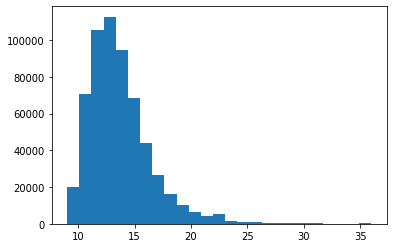

In [13]:
lens = [torch.sum(cap[2]).item() for cap in train_captions]
plt.hist(lens, bins=25)
print(max(lens))
print(sum(lens)/len(lens))
#out = len([l for l in lens if l == MAX_LENGTH])
#print(out, " (absolute) ", round(out / len(lens) * 100, 2), "% (percentual)", sep="")

In [14]:
class CaptionDataset(Dataset):
    
    tfms = transforms.Compose([transforms.Resize(IMG_SIZE), # First set the min dimension to 380
                               transforms.CenterCrop(IMG_SIZE), # Then center crop
                               transforms.ToTensor(), # Then to Tensor
                               #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Finally normalize with ImageNet mean and variance
                               transforms.Lambda(lambda img: img * 2.0 - 1.0) # AdvProp Normalization
                              ])
    
    def __init__(self, captions, images_path, random_transform=False):
        self.captions = captions
        self.images_path = images_path
        self.random_transform = random_transform

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, index):
        image_id = self.captions[index][0]
        tokens = self.captions[index][1]
        mask = self.captions[index][2]

        path = os.path.join(self.images_path, image_id + ".jpg")
        image = Image.open(path).convert('RGB')
        trans = self.tfms(image)
        
        return trans.cuda(), tokens.cuda(), mask.cuda()

In [15]:
BS = 8 #2
BS_VAL = 16

train_data = CaptionDataset(train_captions, TRAIN_IMAGES)
train_generator = DataLoader(train_data, batch_size=BS, shuffle=True, num_workers=0)

valid_data = CaptionDataset(valid_captions, VALID_IMAGES)
valid_generator = DataLoader(valid_data, batch_size=BS_VAL, shuffle=False, num_workers=0)

In [16]:
t = time.time()
for images, texts, masks in train_generator:
    print(len(texts))
    break
print(time.time()-t)

8
0.2184157371520996


# Training Hyperparameters

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

#model, optimizer = amp.initialize(model, optimizer, opt_level="O1")

# Training Loop

In [17]:
def validate():
    print("Validating...")
    model.eval()
    
    # Evaluate
    sum_loss, start = 0, time.time()
    with torch.no_grad():
        for idx, (images, texts, masks) in enumerate(valid_generator):
            images_c, texts_c, masks_c = images.cpu(), texts.cpu(), masks.cpu()
            
            try:
                loss, _, _ = model((texts, images), labels=texts, attention_mask=masks)
                sum_loss += loss.item()
            except:
                print(idx)
                print(images_c, texts_c, masks_c)
                print([tokenizer.decode(text) for text in texts_c])
                print(loss.item())
    
    print("Valid Loss:", round(sum_loss / len(valid_generator), 3))
    print("Time: ", round(time.time() - start), "s")
    
    model.train()
    
    return sum_loss / len(valid_generator)

In [18]:
"""
Valid Loss: 7.265
Time:  460 s
11355.9609375
"""

#validate()

'\nValid Loss: 7.265\nTime:  460 s\n11355.9609375\n'

In [19]:
from tensorboardX import SummaryWriter

writer = SummaryWriter("runs/8bs_3e5lr_386hidden1_256hidden2_1")
writer.add_scalar("valid_loss", 7.265, 0)

In [22]:
EPOCHS = 10
ACCUM = 1
EVERY = 100 * ACCUM
EVERY_VAL = 4000 * ACCUM
EVERY_SAVE = 4000 * ACCUM

best = 10e9
for epoch in range(EPOCHS):
    print("\nEpoch", epoch + 1)
    sum_loss, start = 0, time.time()
    for idx, (images, texts, masks) in enumerate(train_generator):
        
        loss, outputs, _ = model((texts, images), labels=texts, attention_mask=masks)
        
        sum_loss += loss.item()
        #with amp.scale_loss(loss, optimizer) as scaled_loss:
        #    scaled_loss.backward()
        loss.backward()
        
        if idx % ACCUM == ACCUM - 1:
            optimizer.step()
            optimizer.zero_grad()
        
        if idx % EVERY == EVERY - 1:
            print(round(100 * BS * idx / len(train_captions), 1), "% completed;", round(time.time() - start), "s")
            print("Loss:", round(sum_loss / EVERY, 3))
            writer.add_scalar("train_loss", sum_loss / EVERY, epoch * len(train_generator) + idx)
            writer.add_scalar("time", start, epoch * len(train_generator) + idx)
            
            sum_loss = 0
        
        if idx % EVERY_VAL == EVERY_VAL - 1:
            outputs = None
            act = validate()
            if act < best:
                best = act
                torch.save(model.state_dict(), str(round(best, 3)) + ".torch")
            writer.add_scalar("valid_loss", act, epoch * len(train_generator) + idx)
            
        
        if idx % EVERY_SAVE == EVERY_SAVE - 1:
            print("Model checkpoint saved!")
            torch.save(model.state_dict(), "last_checkpoint.torch")
    
    torch.save(model.state_dict(), str(epoch) + ".torch")


Epoch 1
0.1 % completed; 81 s
Loss: 1.372


KeyboardInterrupt: 

In [23]:
model.load_state_dict(torch.load("1.torch"))

<All keys matched successfully>

# Testing Loop

In [24]:
class CaptionDatasetTest(Dataset):
    
    tfms = transforms.Compose([transforms.Resize(IMG_SIZE), # First set the min dimension to 380
                               transforms.CenterCrop(IMG_SIZE), # Then center crop
                               transforms.ToTensor(), # Then to Tensor
                               transforms.Lambda(lambda img: img * 2.0 - 1.0) # AdvProp Normalization
                               #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Finally normalize with ImageNet mean and variance
                              ])
    
    tfms2 = transforms.Compose([transforms.Resize(IMG_SIZE), # First set the min dimension to 380
                               transforms.CenterCrop(IMG_SIZE), # Then center crop
                              ])
    
    def __init__(self, images_path):
        self.images_path = images_path
        self.names = [file for file in os.listdir(images_path) if file[-4:] == ".jpg"]

    def __len__(self):
        return len(self.names)

    def __getitem__(self, index):
        path = os.path.join(self.images_path, self.names[index])
        image = Image.open(path).convert('RGB')
        
        trans = self.tfms(image)
        
        return np.array(self.tfms2(image)), trans.cuda()

TEST_IMAGES = "data/test_images"
test_data = CaptionDatasetTest(TEST_IMAGES)
test_generator = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=0)

In [26]:
MAGIC_TOKEN = tokenizer.encode("<|endoftext|>")[0]

def choose_from_top(probs, n=5):
    ind = np.argpartition(probs, -n)[-n:] # last n indices sorted, rest random
    top_prob = probs[ind] # get the top n probs
    top_prob = top_prob / np.sum(top_prob) # normalize to have probability 1
    choice = np.random.choice(n, 1, p=top_prob) # choose 1 from top_prob distro
    token_id = ind[choice][0] # get the index in the original list
    return int(token_id)

def generate_some_text(input_str, image, text_len=30):
    cur_ids = torch.tensor(tokenizer.encode(input_str)).unsqueeze(0).long().cuda()
    #cur_ids = torch.zeros((1, 0)).unsqueeze(0).long().cuda()
    
    model.eval()
    global MAX_LENGTH
    global MAGIC_TOKEN
    
    with torch.no_grad():
        for i in range(text_len):
            outputs = model((cur_ids, image), labels=cur_ids)
            loss, logits = outputs[:2]
            softmax_logits = torch.softmax(logits[0,-1], dim=0) #Take the first(only one) batch and the last predicted embedding
            next_token_id = choose_from_top(softmax_logits.to('cpu').numpy(), n=10) #Randomly(from the given probability distribution) choose the next word from the top n words
            if next_token_id == MAGIC_TOKEN:
                break
            cur_ids = torch.cat([cur_ids, torch.ones((1,1)).long().cuda() * next_token_id], dim = 1) # Add the last word
            MAX_LENGTH += 1

        output_list = list(cur_ids.squeeze().to('cpu').numpy())[1:]
        output_text = tokenizer.decode(output_list)
        print(output_text)

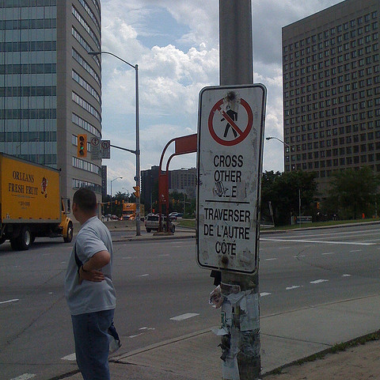

AttributeError: 'tuple' object has no attribute 'shape'

In [51]:
MAX_LENGTH = 1
for images, tensors in test_generator:
    image, tensor = images[0], tensors[0]
    tensor = tensor.unsqueeze(0)
    display(Image.fromarray(image.numpy()))
    #generate_some_text("<|endoftext|>", tensor)
    beam_output = model.generate(
        ("<|endoftext|>", tensor), 
        max_length=50, 
        num_beams=5, 
        no_repeat_ngram_size=2, 
        early_stopping=True
    )
    break

In [ ]:
from PIL import Image
nump = img.squeeze(0).reshape(260, 260, 3).cpu().numpy()
plt.imshow(nump)

In [ ]:
with open("data/valid_captions.pickle", "rb") as handler:
    captions = pickle.load(handler)

for caption in captions:
    if "people sitting" in caption.text:
        print(caption)